In [96]:
import numpy as np
import matplotlib.pyplot as plt
import os, glob
from osgeo import gdal
import earthpy as et
import geopandas as gpd
import rioxarray as rxr
import xarray as xr
from shapely.geometry  import box
from tifffile import imsave
from rioxarray.merge import merge_arrays
from rasterio.plot import plotting_extent
import earthpy.plot as ep
import rasterio
from rasterio.plot import show

In [244]:
# data paths

nitrogen_path = os.path.join(et.io.HOME, 
                             'desktop', 
                             'earth-analytics', 
                             'python', 
                             'final-project', 
                             'nitrogen')

phosphorus_path = os.path.join(et.io.HOME, 
                             'desktop', 
                             'earth-analytics', 
                             'python', 
                             'final-project', 
                             'phosphorus')

nitrogen_to_mosaic = glob.glob(os.path.join(str(nitrogen_path), "*.tif"))

phosphorus_to_mosaic = glob.glob(os.path.join(str(phosphorus_path), "*.tif"))


# crop path


rr_hu8_path = os.path.join(et.io.HOME,
                           'desktop',
                           'earth-analytics',
                           'python',
                           'final-project',
                           'polygon',
                           'RR_HU8-polygon.shp')

rr_hu8_boundary = gpd.read_file(rr_hu8_path)




'/Users/merielle/desktop/earth-analytics/python/final-project/rxr-clipped'

# Functions section

### rxr library

In [85]:

# function for clipping to shp and opening with rioxarray 

def open_clean_bands(band_path,
                     crop_bound,
                     valid_range=None,
                     variable=None):
    # YOUR CODE HERE

    """Open and clean a single landsat band .

    Parameters
    -----------
    band_path:string A path to the array to be opened
    crop_bound:geopandas GeoDataFrame
    A geopandas dataframe to be used to crop the raster data using rioxarray clip().
    valid_range:tuple (optional)
     A tuple of min and max range of values for the data. Default = None

    Returns
    -----------
     band : xarray DataArray
        An xarray DataArray clipped to a crop boundary and masked if a range is given
    """

    crop_bound_box = [box(*crop_bound.bounds.loc[0])]

    try:
        band = rxr.open_rasterio(band_path,
                                 masked=True,
                                 variable=variable, 
                                 parse_coordinates=False).rio.clip(crop_bound_box,
                                                             #crs=crop_bound.crs,
                                                             all_touched=True,
                                                             from_disk=True).squeeze()
    except:
        raise ValueError(
            "Oops - I couldn't clip your data. This may be due to a crs error.")

    # Only mask the data to the valid range if a valid range tuple is provided
    if valid_range is not None:
        mask = ((band < valid_range[0]) | (band > valid_range[1]))
        band = band.where(~xr.where(mask, True, False))

    return band


### GDAL library

In [6]:
# function for converting to raster after using GDAL merge command 

def raster2array(geotif_file):
    metadata = {}
    dataset = gdal.Open(geotif_file)
    metadata['array_rows'] = dataset.RasterYSize
    metadata['array_cols'] = dataset.RasterXSize
    metadata['bands'] = dataset.RasterCount
    metadata['driver'] = dataset.GetDriver().LongName
    metadata['projection'] = dataset.GetProjection()
    metadata['geotransform'] = dataset.GetGeoTransform()

    mapinfo = dataset.GetGeoTransform()
    metadata['pixelWidth'] = mapinfo[1]
    metadata['pixelHeight'] = mapinfo[5]

    xMin = mapinfo[0]
    xMax = mapinfo[0] + dataset.RasterXSize/mapinfo[1]
    yMin = mapinfo[3] + dataset.RasterYSize/mapinfo[5]
    yMax = mapinfo[3]

    metadata['extent'] = (xMin,xMax,yMin,yMax)

    raster = dataset.GetRasterBand(1)
    array_shape = raster.ReadAsArray(0,0,metadata['array_cols'],metadata['array_rows']).astype(float).shape
    metadata['noDataValue'] = raster.GetNoDataValue()
    metadata['scaleFactor'] = raster.GetScale()

    array = np.zeros((array_shape[0],array_shape[1],dataset.RasterCount),'uint8') #pre-allocate stackedArray matrix

    if metadata['bands'] == 1:
        raster = dataset.GetRasterBand(1)
        metadata['noDataValue'] = raster.GetNoDataValue()
        metadata['scaleFactor'] = raster.GetScale()

        array = dataset.GetRasterBand(1).ReadAsArray(0,0,metadata['array_cols'],metadata['array_rows']).astype(float)
        array[np.where(array==metadata['noDataValue'])]=np.nan
        array = array/metadata['scaleFactor']

    elif metadata['bands'] > 1:    
        for i in range(1, dataset.RasterCount+1):
            band = dataset.GetRasterBand(i).ReadAsArray(0,0,metadata['array_cols'],metadata['array_rows']).astype(float)
            band[np.where(band==metadata['noDataValue'])]=np.nan
            #band = band/metadata['scaleFactor']
            array[...,i-1] = band

    return array, metadata

### plotting

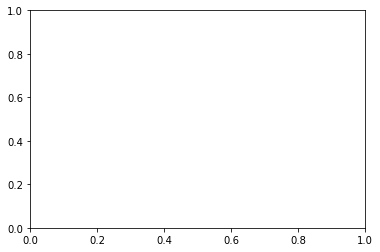

In [7]:
# plotting function

def plot_array(array,spatial_extent,colorlimit,ax=plt.gca(),title='',cmap_title='',colormap=''):
    plot = plt.imshow(array,extent=spatial_extent,clim=colorlimit); 
    cbar = plt.colorbar(plot,aspect=40); plt.set_cmap(colormap); 
    cbar.set_label(cmap_title,rotation=90,labelpad=20);
    plt.title(title); ax = plt.gca(); 
    ax.ticklabel_format(useOffset=False, style='plain'); 
    rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90);

# Clipping section

### rxr library

In [303]:

# prep shapefile for clipping 

# convert to crs of original raster

rr_hu8_boundary_crs = rr_hu8_boundary.to_crs('EPSG:32610')




In [246]:

# run function for clipping and cleaning nitrogen tifs (outputs a list of arrays)

nitrogen_tiles = []
for image, i in zip(nitrogen_to_mosaic, range(0,10)):
    tile = open_clean_bands(image,
                            rr_hu8_boundary_crs,
                            valid_range=(0,1000),
                            variable=None)
    nitrogen_tiles.append(tile)
    

### GDAL library

In [ ]:
# GDAL library uses Warp() for clipping


for image, i in zip(nitrogen_to_mosaic, range(0,10)):
    nitrogen_clip_gdal = gdal.Warp("/Users/merielle/desktop/earth-analytics/python/final-project/nitrogen-clips-gdal/nitrogen-rr-hu8-crop-gdal{}.tif".format(i), 
    image, 
    cutlineDSName='/Users/merielle/desktop/earth-analytics/python/final-project/polygon/RR_HU8-polygon.shp',
    cropToCutline=True,
    dstNodata = 0)



# Merging Section

### rxr library

In [200]:
# rearrange list of arrays from output of open_clean_bands

# order 1

rxr_order1 = [3, 0, 1, 2, 6, 7, 4, 8, 9, 5]

rxr_tiles_order1 = [nitrogen_tiles[i] for i in rxr_order1]


# order 2

rxr_order2 = [0, 5, 6, 4, 7, 8, 1, 3, 9, 2]

rxr_tiles_order2 = [nitrogen_tiles[i] for i in rxr_order2]



In [206]:

# merge list of arrays for mosaic

# order 1

merged_nitrogen_order1 = merge_arrays(rxr_tiles_order1)

mask = (merged_nitrogen_order1 == 0)
merged_nitrogen_mask1 = (merged_nitrogen_order1.where(~xr.where(mask, True, False)))
    
    
# order2

merged_nitrogen_order2 = merge_arrays(rxr_tiles_order2)

mask = (merged_nitrogen_order2 == 0)
merged_nitrogen_mask2 = (merged_nitrogen_order2.where(~xr.where(mask, True, False)))

In [137]:
# plot extent

nitrogen_extent = plotting_extent(merged_nitrogen[0],
                              merged_nitrogen.rio.transform())

## GDAL library

### plots 2&3

In [318]:
# file paths to rxr cropped rasters

nitrogen_clipped_path = os.path.join(et.io.HOME, 
                                'desktop', 
                                'earth-analytics', 
                                'python', 
                                'final-project', 
                                'nitrogen', 
                                'clipped')

nitrogen_clipped_to_mosaic = glob.glob(os.path.join(str(nitrogen_clipped_path), "*.tif"))




In [319]:
# rearrange rxr clipped files


# order 1

order1 = [3, 1, 0, 2, 4, 7, 6, 8, 5, 9]

nitrogen_rxr_crop_to_mosaic_order1 = [nitrogen_clipped_to_mosaic[i] for i in order1]


string_nitrogen_rxr_crop_to_mosaic_order1 = " ".join(nitrogen_rxr_crop_to_mosaic_order1)

# order 2

order2 = [9, 5, 4 ,7, 8, 2, 3, 6, 1, 0]

nitrogen_rxr_crop_to_mosaic_order2 = [nitrogen_clipped_to_mosaic[i] for i in order2]


string_nitrogen_rxr_crop_to_mosaic_order2 = " ".join(nitrogen_rxr_crop_to_mosaic_order2)



In [308]:
# merge rxr clipped files with 2 different orderings using gdal merge


# order1

command_nitrogen1 = "gdal_merge.py -o /Users/merielle/desktop/earth-analytics/python/final-project/nitrogen-mosaic-clipped-rxr-order1.tif -of gtiff " + string_nitrogen_rxr_crop_to_mosaic_order1

print(os.popen(command_nitrogen1).read())



0...10...20...30...40...50...60...70...80...90...100 - done.



In [309]:
# order2

command_nitrogen2 = "gdal_merge.py -o /Users/merielle/desktop/earth-analytics/python/final-project/nitrogen-mosaic-clipped-rxr-order2.tif -of gtiff " + string_nitrogen_rxr_crop_to_mosaic_order2

print(os.popen(command_nitrogen2).read())



Creation failed, terminating gdal_merge.



### plots 4&5

In [262]:
# file paths for GDAL clipped rasters


nitrogen_crop_gdal_path = os.path.join(et.io.HOME, 
                                'desktop', 
                                'earth-analytics', 
                                'python', 
                                'final-project', 
                                'nitrogen-clips-gdal')

nitrogen_crop_gdal_to_mosaic = glob.glob(
    os.path.join(str(nitrogen_crop_gdal_path), "*.tif"))



In [263]:
# rearrange GDAL clipped rasters to test out different orderings


# order 1

order1 = [3, 0, 1, 2, 6, 7, 4, 8, 9, 5]

nitrogen_crop_gdal_to_mosaic_order1 = [nitrogen_crop_gdal_to_mosaic[i] for i in order1]


nitrogen_string_gdal_clip_order1 = " ".join(nitrogen_crop_gdal_to_mosaic_order1)

# order 2

order2 = [9, 5, 4 ,7, 8, 2, 3, 6, 1, 0]

nitrogen_crop_gdal_to_mosaic_order2 = [nitrogen_crop_gdal_to_mosaic[i] for i in order2]


nitrogen_string_gdal_clip_order2 = " ".join(nitrogen_crop_gdal_to_mosaic_order2)



In [231]:
# merge rasters 


# order 1

command_nitrogen1 = "gdal_merge.py -o /Users/merielle/desktop/earth-analytics/python/final-project/nitrogen-mosaic-clipped-order1.tif -of gtiff " + nitrogen_string_gdal_clip_order1

print(os.popen(command_nitrogen2).read())




# order 2

command_nitrogen2 = "gdal_merge.py -o /Users/merielle/desktop/earth-analytics/python/final-project/nitrogen-mosaic-clipped-order2.tif -of gtiff " + nitrogen_string_gdal_clip_order2

print(os.popen(command_nitrogen2).read())




0...10...20...30...40...50...60...70...80...90...100 - done.



### convert merged rasters to arrays for plotting

In [337]:
# file paths to merged rasters

nitrogen_mosaic_gdal_clipped_path = os.path.join(et.io.HOME, 
                                    'desktop', 
                                    'earth-analytics', 
                                    'python', 
                                    'final-project', 
                                    'nitrogen-mosaic-rr-hu8-crop-gdal.tif')


nitrogen_mosaic_path_order1 = os.path.join(et.io.HOME, 
                                    'desktop', 
                                    'earth-analytics', 
                                    'python', 
                                    'final-project', 
                                    'nitrogen-mosaic-clipped-order1.tif')

nitrogen_mosaic_path_order1 = os.path.join(et.io.HOME, 
                                    'desktop', 
                                    'earth-analytics', 
                                    'python', 
                                    'final-project', 
                                    'nitrogen-mosaic-clipped-order2.tif')


nitrogen_mosaic_path_rxr_order1 = os.path.join(et.io.HOME, 
                                    'desktop', 
                                    'earth-analytics', 
                                    'python', 
                                    'final-project', 
                                    'nitrogen-mosaic-clipped-rxr-order1.tif')



nitrogen_mosaic_path_rxr_order2 = os.path.join(et.io.HOME, 
                                    'desktop', 
                                    'earth-analytics', 
                                    'python', 
                                    'final-project', 
                                    'nitrogen-mosaic-rxr-clipped-order2.tif')




'/Users/merielle/desktop/earth-analytics/python/final-project/nitrogen-mosaic-clipped-rxr-order1.tif'

In [317]:
# convert rasters to arrays for plotting

nitrogen_crop_array_gdal, nitrogen_crop_gdal_metadata = raster2array(
    nitrogen_mosaic_gdal_clipped_path)



In [327]:
nitrogen_crop_array_rxr_order1, nitrogen_crop_rxr_order1_metadata = raster2array(
    '/Users/merielle/desktop/earth-analytics/python/final-project/nitrogen-mosaic-clipped-order1.tif')




In [328]:
nitrogen_crop_array_gdal_order2, nitrogen_crop_gdal_order2_metadata = raster2array(
    nitrogen_mosaic_path_order2)

In [338]:
nitrogen_crop_array, nitrogen_crop_metadata = raster2array(
    nitrogen_mosaic_path_rxr_order1)

AttributeError: 'NoneType' object has no attribute 'astype'

In [ ]:
nitrogen_crop_array, nitrogen_crop_metadata = raster2array(
    nitrogen_mosaic_path_rxr_order2)

# Plotting Section

## plot 1: rxr clipped and merged

/Users/merielle/opt/anaconda3/envs/earth-analytics-python/lib/python3.6/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("jet"))
  if sys.path[0] == '':


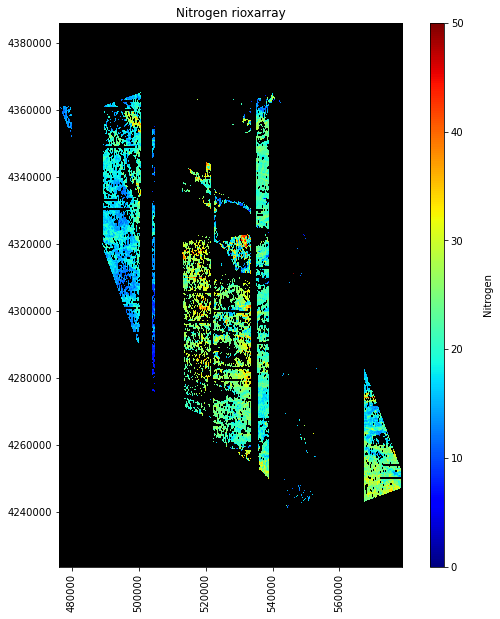

In [210]:
fig, ax = plt.subplots(figsize=(10,10))


plot_array(merged_nitrogen_mask2[0,:,:],
           nitrogen_extent,
           (0,50),
           title='Nitrogen rioxarray',
           cmap_title='Nitrogen',
           colormap='jet')



# set no data values to black

current_cmap = plt.cm.get_cmap()
current_cmap.set_bad(color='black')


## rxr clipped, GDAL merged

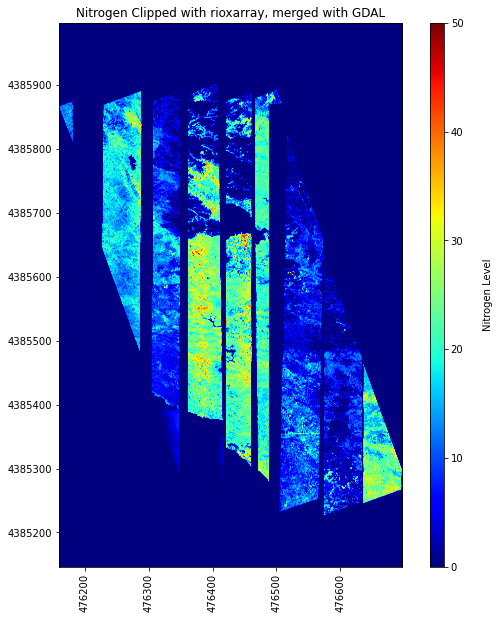

In [154]:
fig, ax = plt.subplots(figsize=(10,10))


plot_array(nitrogen_crop_array_rxr[:,:,0],
           nitrogen_crop_rxr_metadata['extent'],
           (0,50),
           title='Nitrogen Clipped with rioxarray, merged with GDAL',
           cmap_title='Nitrogen Level',
           colormap='jet')




In [ ]:
fig, ax = plt.subplots(figsize=(10,10))


plot_array(nitrogen_crop_array[:,:,0],
           nitrogen_crop_metadata['extent'],
           (0,70),
           title='Nitrogen',
           cmap_title='Nitrogen Level',
           colormap='jet')




## clipped and merged with GDAL

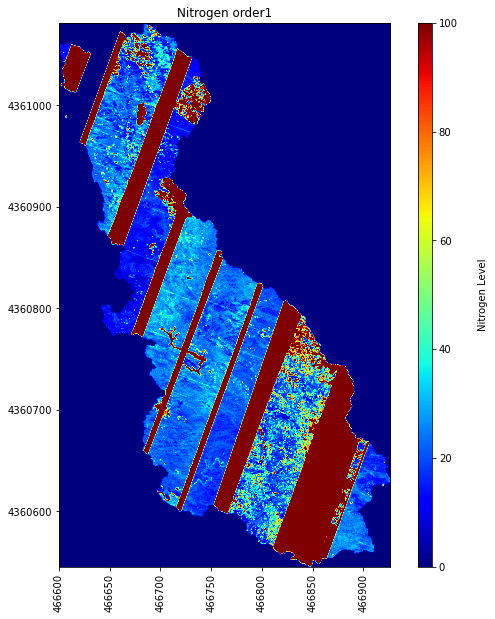

In [278]:
fig, ax = plt.subplots(figsize=(10,10))


plot_array(nitrogen_crop_array_gdal_order1[:,:,0],
           nitrogen_crop_gdal_order1_metadata['extent'],
           (0,100),
           title='Nitrogen order1',
           cmap_title='Nitrogen Level',
           colormap='jet')








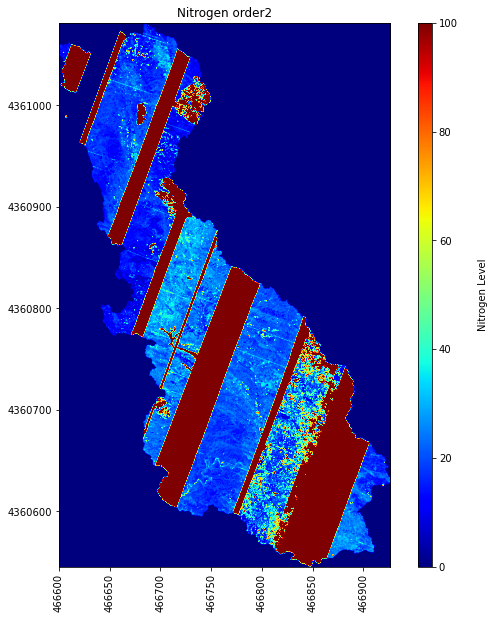

In [279]:
fig, ax = plt.subplots(figsize=(10,10))


plot_array(nitrogen_crop_array_gdal_order2[:,:,0],
           nitrogen_crop_gdal_order2_metadata['extent'],
           (0,100),
           title='Nitrogen order2',
           cmap_title='Nitrogen Level',
           colormap='jet')







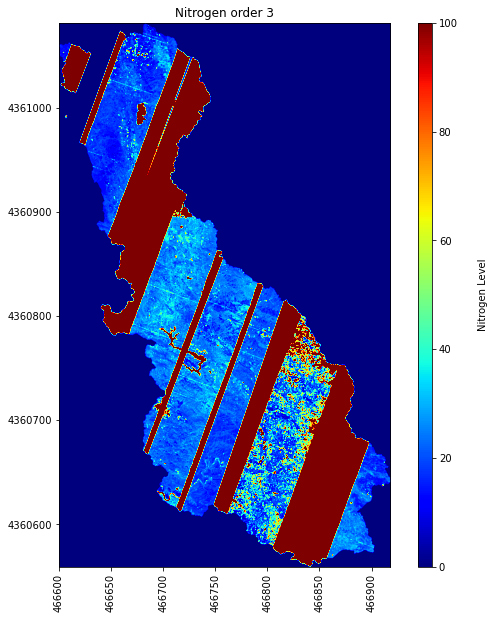

In [282]:
fig, ax = plt.subplots(figsize=(10,10))


plot_array(nitrogen_crop_array_gdal[:,:,0],
           nitrogen_crop_gdal_metadata['extent'],
           (0,100),
           title='Nitrogen order 3',
           cmap_title='Nitrogen Level',
           colormap='jet')

